# ML - Analiza Skupień

## 1. Przygotować zbiór danych do pracy

Naszym zbiorem danych, dla którego wykonamy zadanie będzie zbiór obrazków o wymiarach 8x8 przedstawiających cyfry.

In [12]:
from sklearn.datasets import load_digits

digits = load_digits()
digits_data = digits.data
digits_target = digits.target

digits_data.shape

(1797, 64)

In [13]:
import matplotlib.pyplot as plt

# funkcja sluzy do wyswietlania obrazkow
# x i y to ilość obrazków w poziomie i w pionie
def printImgs(data, x, y):
    ig, ax = plt.subplots(y, x, figsize=(8, 3))
    imgs = data.reshape(x*y, 8, 8)
    for axi, img in zip(ax.flat, imgs):
        axi.set(xticks=[], yticks=[])
        axi.imshow(img, cmap=plt.cm.binary)

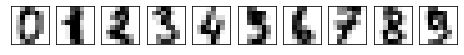

In [27]:
printImgs(digits_data[:10], 10, 1)

## 2. Popularne algorymty w analizie skupień

Uczenie nienadzorowane – to rodzaj uczenia maszynowego, którego zadaniem jest odkrywaniem w zbiorze danych wzorców bez wcześniej istniejących etykiet i przy minimalnej ingerencji człowieka. Uczenie nienadzorowane zakłada brak obecności oczekiwanego wyjścia w danych uczących.

Dwie główne metody stosowane w uczeniu nienadzorowanym to analiza składowych głównych oraz **analiza skupień**. Analiza skupień jest wykorzystywana w celu grupowania lub segmentowania zestawów danych ze wspólnymi atrybutami w celu ekstrapolacji występujących w nich zależności. Analiza skupień identyfikuje podobieństwa w danych i pozwala na grupowanie danych, które nie zostały oznaczone, sklasyfikowane ani skategoryzowane. Ponieważ analiza skupień bazuje na obecności lub braku takich podobieństw w nowej danych, może być wykorzystana aby wykryć nietypowe dane, które nie pasują do żadnej grupy. 

Jest to przegląd trzech najbardziej popularnych metod grupowania i charakterystyka, do jakich rodzajów sytuacji każda z nich nadaje się najlepiej.

### K-Means Clustering

Zaczniemy od załadowania cyfr, a następnie znalezienia klastrów KMeans. Przypomnijmy, że cyfry składają się z 1797 próbek z 64 funkcjami, przy czym każda z 64 cech to jasność jednego piksela na obrazie 8 × 8. Klastrowanie może zostać przygotowane w następujący sposób:

In [21]:
from sklearn.cluster import KMeans

kmeans_example = KMeans(n_clusters=10, random_state=0)
clusters_example = kmeans_example.fit_predict(digits.data)
kmeans_example.cluster_centers_.shape

(10, 64)

Rezultatem jest 10 klastrów w 64 wymiarach. Zauważ, że same centra klastra są punktami 64-wymiarowymi i mogą być interpretowane jako cyfra w klastrze. Zobaczmy, jak wyglądają te centra klastrowe:

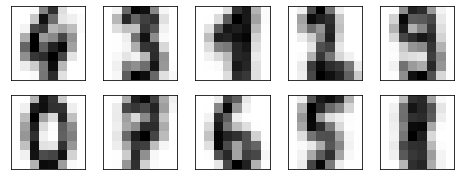

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans_example.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

Widzimy, że nawet bez etykiet jesteśmy w stanie znaleźć klastry - **których centra są rozpoznawalnymi cyframi**. Jak widać możemy odczytać bez problemy cyfry z wyjątkiem jedynki i ósmeki. Widać tutaj jedną z zalet analizy skupień - może być wykorzystana aby wykryć nietypowych dane, które nie pasują do żadnej grupy. W naszym zbiorze cyfry 1 i 8 są takimi danymi (nie pasują do siebie).  

Ponieważ K-Means nic nie wie o tożsamości klastra, etykiety 0–9 mogą być permutowane. Możemy to wpłynąć na rezulalt dopasowując każdą wyuczoną etykietę klastra do prawdziwych etykiet w niej znalezionych.

In [28]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Teraz możemy sprawdzić, jak dokładna była nasza nienadzorowana funkcja grupowania w znajdowaniu podobnych cyfr w danych:

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

Uzyskaliśmy 80% dokładności (zwykłym grupowaniem!). Możemy również zwizualizować ośrodek skupień:

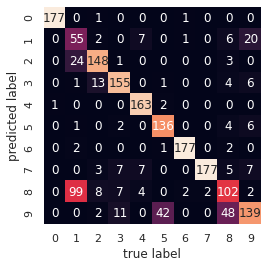

In [32]:
import seaborn as sns; 
from sklearn.metrics import confusion_matrix

sns.set()
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

Jak można się spodziewać po wizualizowanych wcześniej ośrodkach skupień, głównym punktem pomieszania jest ósemka i jedynka. Ale to wciąż pokazuje, że używając algorytmu K-Means, możemy zasadniczo zbudować cyfrowy klasyfikator bez odwoływania się do jakichkolwiek znanych etykiet!

### Paritioning Around Medoids

### Hierarchical Clustering

## 4a. Zadanie

Dla zbioru z początku tutoriala wykorzystaj metodę k-means do rozpoznawania cyfr

In [34]:
from sklearn.cluster import KMeans

def fitAndPredictKMeans(data):
    # Stwórz klasyfikator KMeans z odpowiednią ilością klastrów
    kmeans = # todo
    
    # Wytrenuj klasyfikator dla danych i zwróc predycje dla tych danych
    clusters = # todo
    return (kmeans, clusters)

In [35]:
def compareWithTarget(clusters, digits_target):
    labels = np.zeros_like(clusters)
    for i in range(10):
        mask = (clusters == i)
        labels[mask] = mode(digits_target[mask])[0]
    print(accuracy_score(digits_target, labels))

In [36]:
def printCentroids(cluster_centers):
    ig, ax = plt.subplots(2, 5, figsize=(8, 3))
    centers = cluster_centers.reshape(10, 8, 8)
    for axi, center in zip(ax.flat, centers):
        axi.set(xticks=[], yticks=[])
        axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [38]:
# Wykorzystaj 3 przedstawione wyżej funkcje do sprawdzenia jakości predykcji i narysowaniu centroidów klastrów
# Podpowiedź: centroidy klastrów osiąga się przez kmeans.cluster_centers_

kmeans, clusters = # todo
printCentroids(# todo)
compareWithTarget(# todo)

## 4b. Zadanie

Zrób to samo dla metod grupowania wokół centroidów i aglomeracyjnego klastrowania hierarchicznego.

Dla grupowania wokół centroidów sprawdź rezultaty dla zastosowania różnych metryk (np. "manhattan", "cosine", "euclidean").

Zwróć uwagę, że dla aglomeracyjnego klastrowania hierarchicznego funkcja printCentroids nie ma zastosowania, ponieważ przy tej metodzie nie wyznaczamy centroidów. Tutaj wystarczy wypisanie dokładności rozwiązania.

Krótko skomentuj otrzymane wyniki: